<a href="https://colab.research.google.com/github/francescopatane96/Bioactivity-prediction-with-ML/blob/main/clustering5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 423 kB/s 


In [9]:
!pip install git+https://github.com/volkamerlab/teachopencadd.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/volkamerlab/teachopencadd.git to /tmp/pip-req-build-v6ekzr6p
  Running command git clone -q https://github.com/volkamerlab/teachopencadd.git /tmp/pip-req-build-v6ekzr6p
  Created wheel for teachopencadd: filename=teachopencadd-2022.9.0+2.g8f2c87a-py3-none-any.whl size=108231919 sha256=7a6176ee4ada6615b93831f57cd9186302abdeb9d94f72048fe34ca367b77b90
  Stored in directory: /tmp/pip-ephem-wheel-cache-ggg1d_3d/wheels/ee/da/82/b2c07c8ddbf7e09a56a283a394ebff26d956480b85a9ef011f
Successfully built teachopencadd


In [10]:
import time
import random
from pathlib import Path

import pandas as pd
import numpy
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator

from teachopencadd.utils import seed_everything

seed_everything()  # fix seed to get deterministic outputs

In [11]:
# Load and have a look into data
# Filtered data taken from **Talktorial T002**
compound_df = pd.read_csv(
    "TNFB_compounds_lipinski.csv",
    index_col=0,
)
print("Dataframe shape:", compound_df.shape)
compound_df.head()

Dataframe shape: (49, 11)


,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL336546,50.0,nM,O=C(Nc1cc(C(F)(F)F)cc(C(F)(F)F)c1)c1cnc(Cl)nc1...,7.301030,"<img data-content=""rdkit/molecule"" src=""data:i...",436.997743,3,1,5.4387,True
1,CHEMBL131636,170.0,nM,CCCCOC(=O)c1cc(NC(=O)c2cnc(Cl)nc2C(F)(F)F)cc(C...,6.769551,"<img data-content=""rdkit/molecule"" src=""data:i...",469.062788,5,1,5.3768,True
2,CHEMBL134490,280.0,nM,CCOC(=O)c1cc(NC(=O)c2cnc(Cl)nc2C(F)(F)F)cc(C(F...,6.552842,"<img data-content=""rdkit/molecule"" src=""data:i...",441.031488,5,1,4.5966,True
3,CHEMBL135133,380.0,nM,O=C(Nc1ccc(C(F)(F)F)cc1)c1cnc(Cl)nc1C(F)(F)F,6.420216,"<img data-content=""rdkit/molecule"" src=""data:i...",369.010359,3,1,4.4199,True
4,CHEMBL334485,500.0,nM,O=C(Nc1cc(Cl)cc(Cl)c1)c1cnc(Cl)nc1C(F)(F)F,6.301030,"<img data-content=""rdkit/molecule"" src=""data:i...",368.945029,3,1,4.7079,True


In [12]:
# Create molecules from SMILES and store in array
compounds = []
# .itertuples() returns a (index, column1, column2, ...) tuple per row
# we don't need index so we use _ instead
# note how we are slicing the dataframe to only the two columns we need now
for _, chembl_id, smiles in compound_df[["molecule_chembl_id", "smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), chembl_id))
compounds[:5]

[(<rdkit.Chem.rdchem.Mol at 0x7fa5804076c0>, 'CHEMBL336546'),
 (<rdkit.Chem.rdchem.Mol at 0x7fa57d215620>, 'CHEMBL131636'),
 (<rdkit.Chem.rdchem.Mol at 0x7fa585a30530>, 'CHEMBL134490'),
 (<rdkit.Chem.rdchem.Mol at 0x7fa585a30620>, 'CHEMBL135133'),
 (<rdkit.Chem.rdchem.Mol at 0x7fa57d1ef530>, 'CHEMBL334485')]

In [13]:
# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, idx in compounds]

# How many compounds/fingerprints do we have?
print("Number of compounds converted:", len(fingerprints))
print("Fingerprint length per compound:", len(fingerprints[0]))
# NBVAL_CHECK_OUTPUT

Number of compounds converted: 49
Fingerprint length per compound: 2048


In [14]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [15]:
# Example: Calculate single similarity of two fingerprints
# NBVAL_CHECK_OUTPUT
sim = DataStructs.TanimotoSimilarity(fingerprints[0], fingerprints[1])
print(f"Tanimoto similarity: {sim:.2f}, distance: {1-sim:.2f}")

Tanimoto similarity: 0.80, distance: 0.20


In [16]:
# Example: Calculate distance matrix (distance = 1-similarity)
tanimoto_distance_matrix(fingerprints)[0:5]

[0.2021276595744681,
 0.16897506925207761,
 0.039893617021276584,
 0.05315614617940201,
 0.24403183023872677]

In [17]:
# Side note: That looked like a list and not a matrix.
# But it is a triangular similarity matrix in the form of a list
n = len(fingerprints)

# Calculate number of elements in triangular matrix via n*(n-1)/2
elem_triangular_matr = (n * (n - 1)) / 2
print(
    f"Elements in the triangular matrix ({elem_triangular_matr:.0f}) ==",
    f"tanimoto_distance_matrix(fingerprints) ({len(tanimoto_distance_matrix(fingerprints))})",
)
# NBVAL_CHECK_OUTPUT

Elements in the triangular matrix (1176) == tanimoto_distance_matrix(fingerprints) (1176)


In [18]:
def cluster_fingerprints(fingerprints, cutoff=0.2):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In [19]:
# Run the clustering procedure for the dataset
clusters = cluster_fingerprints(fingerprints, cutoff=0.3)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)
# NBVAL_CHECK_OUTPUT

total # clusters:  25
# clusters with only 1 compound:  17
# clusters with >5 compounds:  2
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0


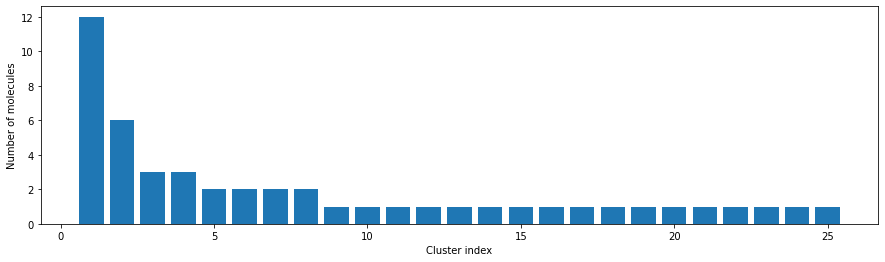

In [20]:
# Plot the size of the clusters
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5);

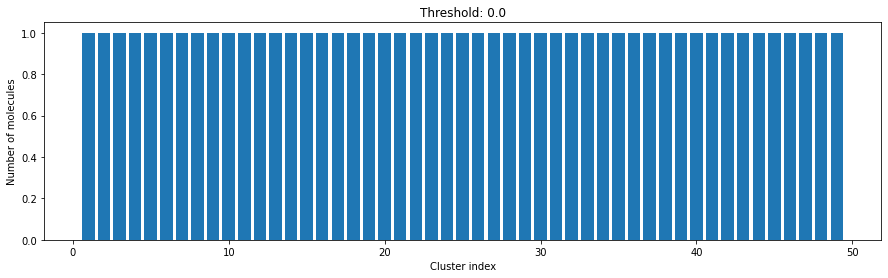

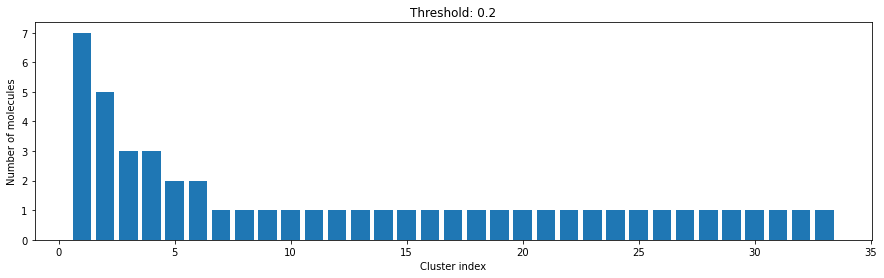

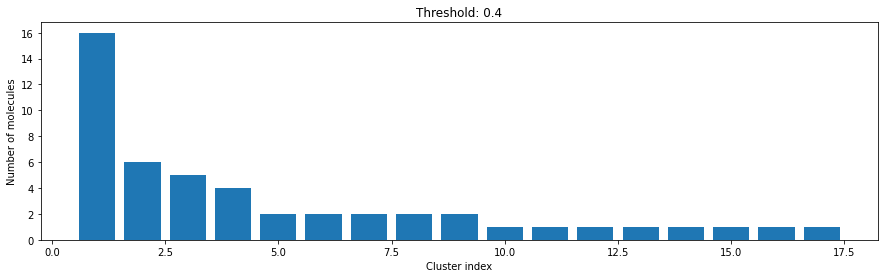

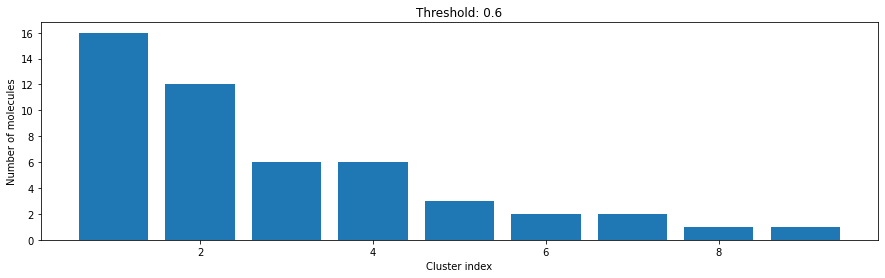

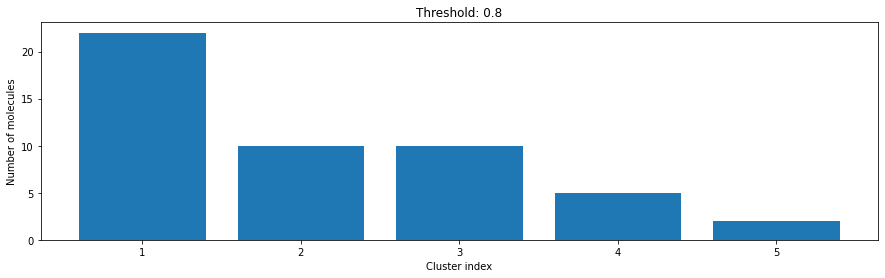

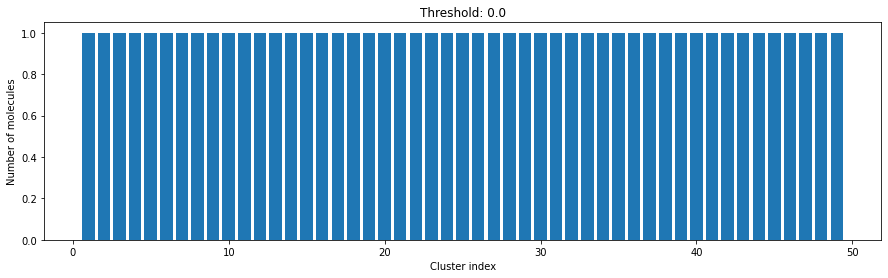

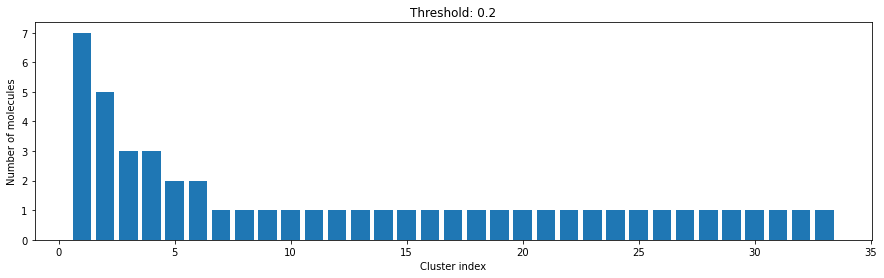

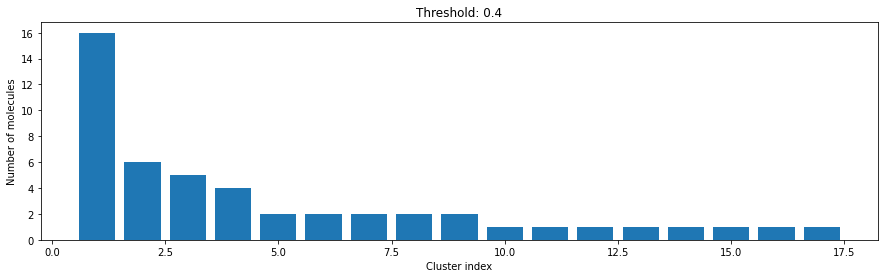

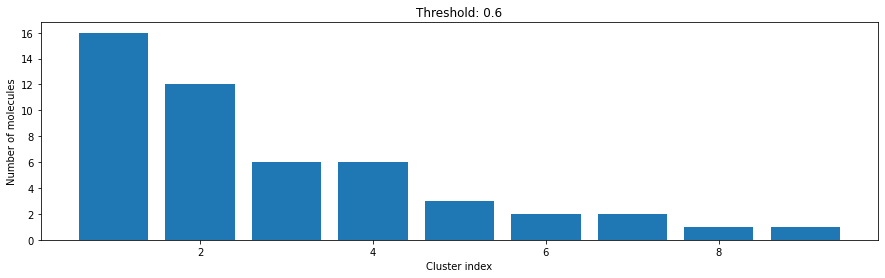

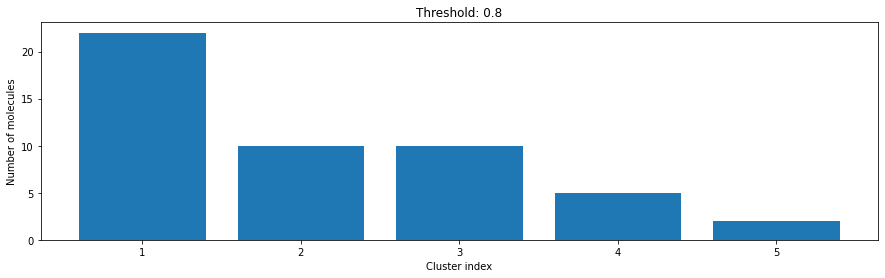

In [21]:
for cutoff in numpy.arange(0.0, 1.0, 0.2):
    clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
    display(fig)

Number of clusters: 33 from 49 molecules at distance cut-off 0.20
Number of molecules in largest cluster: 7
Similarity between two random points in same cluster: 0.84
Similarity between two random points in different cluster: 0.70


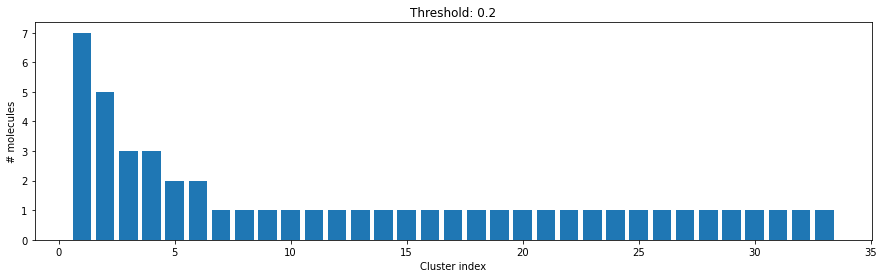

In [23]:
cutoff = 0.2
clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)

# Plot the size of the clusters - save plot
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters])
ax.set_title(f"Threshold: {cutoff:3.1f}")
fig.savefig(
    f"cluster_dist_cutoff_{cutoff:4.2f}.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

print(
    f"Number of clusters: {len(clusters)} from {len(compounds)} molecules at distance cut-off {cutoff:.2f}"
)
print("Number of molecules in largest cluster:", len(clusters[0]))
print(
    f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[0][1]]):.2f}"
)
print(
    f"Similarity between two random points in different cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[1][0]]):.2f}"
)

Ten molecules from largest cluster:


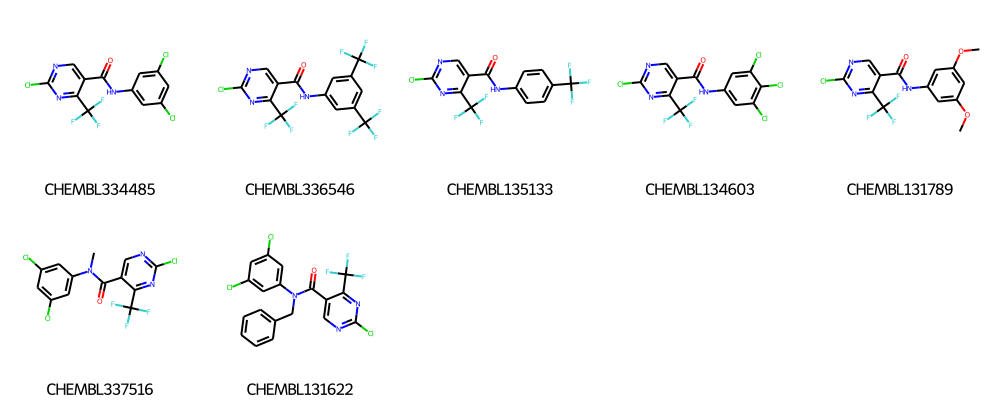

In [24]:
print("Ten molecules from largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[0][:10]],
    legends=[compounds[i][1] for i in clusters[0][:10]],
    molsPerRow=5,
)

In [25]:
# Save molecules from largest cluster so other talktorials can use it
sdf_path = str("molecule_set_largest_cluster.sdf")
sdf = Chem.SDWriter(sdf_path)
for index in clusters[0]:
    mol, label = compounds[index]
    # Add label to metadata
    mol.SetProp("_Name", label)
    sdf.write(mol)
sdf.close()

Ten molecules from second largest cluster:


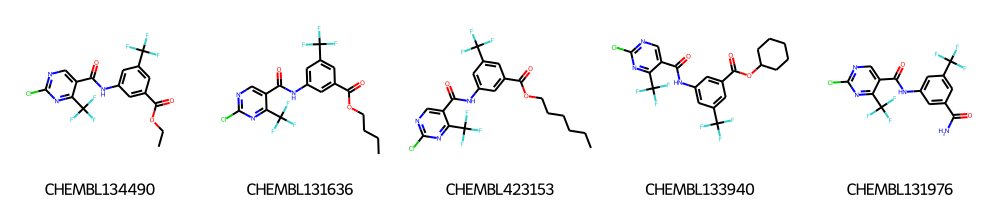

In [26]:
print("Ten molecules from second largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[1][:10]],
    legends=[compounds[i][1] for i in clusters[1][:10]],
    molsPerRow=5,
)

Ten molecules from first 10 clusters:


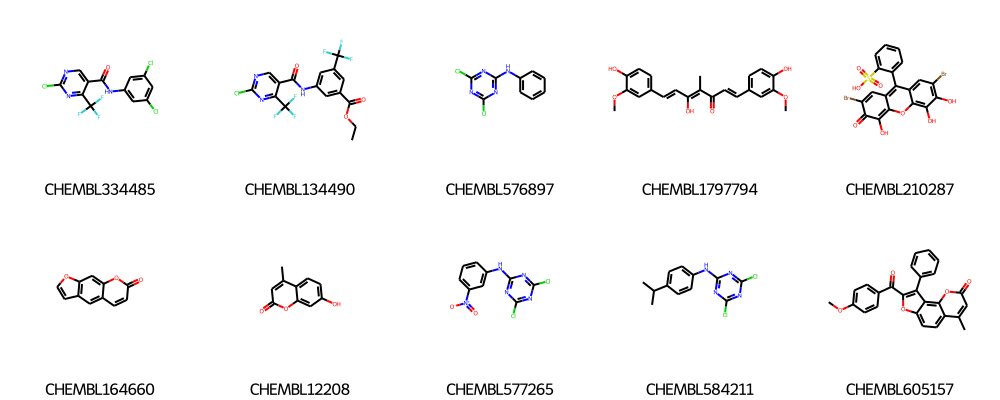

In [27]:
print("Ten molecules from first 10 clusters:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[clusters[i][0]][0] for i in range(10)],
    legends=[compounds[clusters[i][0]][1] for i in range(10)],
    molsPerRow=5,
)

In [30]:
# Generate image
img = Draw.MolsToGridImage(
    [compounds[clusters[i][0]][0] for i in range(0, 3)],
    legends=[f"Cluster {i}" for i in range(1, 4)],
    subImgSize=(200, 200),
    useSVG=True,
)

# Patch RAW svg data: convert non-transparent to transparent background and set font size
molsvg = img.replace("opacity:1.0", "opacity:0.0").replace("12px", "20px")

# Save altered SVG data to file
with open("cluster_representatives.svg", "w") as f:
    f.write(molsvg)

In [31]:
def intra_tanimoto(fps_clusters):
    """Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster"""
    intra_similarity = []
    # Calculate intra similarity per cluster
    for cluster in fps_clusters:
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1 - x for x in tanimoto_distance_matrix(cluster)])
    return intra_similarity

In [32]:
# Recompute fingerprints for 10 first clusters
mol_fps_per_cluster = []
for cluster in clusters[:10]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(compounds[i][0]) for i in cluster])

# Compute intra-cluster similarity
intra_sim = intra_tanimoto(mol_fps_per_cluster)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


ValueError: ignored

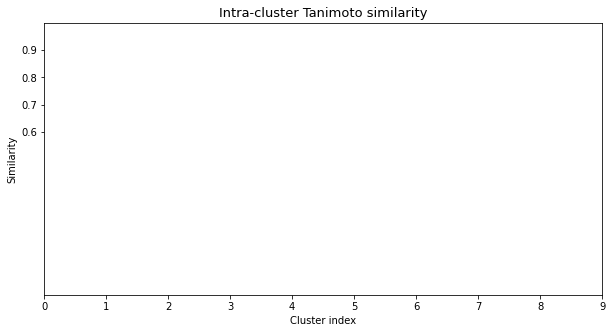

In [33]:
# Violin plot with intra-cluster similarity

fig, ax = plt.subplots(figsize=(10, 5))
indices = list(range(10))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Similarity")
ax.set_xticks(indices)
ax.set_xticklabels(indices)
ax.set_yticks(numpy.arange(0.6, 1.0, 0.1))
ax.set_title("Intra-cluster Tanimoto similarity", fontsize=13)
r = ax.violinplot(intra_sim, indices, showmeans=True, showmedians=True, showextrema=False)
r["cmeans"].set_color("red")
# mean=red, median=blue

In [34]:
# Get the cluster center of each cluster (first molecule in each cluster)
cluster_centers = [compounds[c[0]] for c in clusters]
# How many cluster centers/clusters do we have?
print("Number of cluster centers:", len(cluster_centers))
# NBVAL_CHECK_OUTPUT

Number of cluster centers: 33


In [35]:
# Sort the molecules within a cluster based on their similarity
# to the cluster center and sort the clusters based on their size
sorted_clusters = []
for cluster in clusters:
    if len(cluster) <= 1:
        continue  # Singletons
    # else:
    # Compute fingerprints for each cluster element
    sorted_fingerprints = [rdkit_gen.GetFingerprint(compounds[i][0]) for i in cluster]
    # Similarity of all cluster members to the cluster center
    similarities = DataStructs.BulkTanimotoSimilarity(
        sorted_fingerprints[0], sorted_fingerprints[1:]
    )
    # Add index of the molecule to its similarity (centroid excluded!)
    similarities = list(zip(similarities, cluster[1:]))
    # Sort in descending order by similarity
    similarities.sort(reverse=True)
    # Save cluster size and index of molecules in clusters_sort
    sorted_clusters.append((len(similarities), [i for _, i in similarities]))
    # Sort in descending order by cluster size
    sorted_clusters.sort(reverse=True)

In [36]:
# Count selected molecules, pick cluster centers first
selected_molecules = cluster_centers.copy()
# Take 10 molecules (or a maximum of 50%) of each cluster starting with the largest one
index = 0
pending = 1000 - len(selected_molecules)
while pending > 0 and index < len(sorted_clusters):
    # Take indices of sorted clusters
    tmp_cluster = sorted_clusters[index][1]
    # If the first cluster is > 10 big then take exactly 10 compounds
    if sorted_clusters[index][0] > 10:
        num_compounds = 10
    # If smaller, take half of the molecules
    else:
        num_compounds = int(0.5 * len(tmp_cluster)) + 1
    if num_compounds > pending:
        num_compounds = pending
    # Write picked molecules and their structures into list of lists called picked_fps
    selected_molecules += [compounds[i] for i in tmp_cluster[:num_compounds]]
    index += 1
    pending = 1000 - len(selected_molecules)
print("# Selected molecules:", len(selected_molecules))
# NBVAL_CHECK_OUTPUT

# Selected molecules: 46


In [37]:
# Reuse old dataset
sampled_mols = compounds.copy()

In [38]:
# Helper function for time computation
def measure_runtime(sampled_mols):
    start_time = time.time()
    sampled_fingerprints = [rdkit_gen.GetFingerprint(m) for m, idx in sampled_mols]
    # Run the clustering with the dataset
    sampled_clusters = cluster_fingerprints(sampled_fingerprints, cutoff=0.3)
    return time.time() - start_time

In [39]:
len(sampled_mols)
# NBVAL_CHECK_OUTPUT

49

In [40]:
sample_sizes = [100, 500, 1000, 2000, 4000]
runtimes = []
# Take random samples with replacement
for size in sample_sizes:
    time_taken = measure_runtime(random.sample(sampled_mols, size))
    print(f"Dataset size {size}, time {time_taken:4.2f} seconds")
    runtimes.append(time_taken)

ValueError: ignored